In [116]:
# %pip install matplotlib numpy opencv-python Pillow moviepy    

In [117]:
# %pip freeze

In [118]:
#Importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
from moviepy.editor import VideoFileClip

%matplotlib inline

In [119]:
def list_images(images, cols = 2, rows = 5, cmap=None):
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        cmap = 'gray' if len(image.shape) == 2 else cmap
        plt.imshow(image, cmap = cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

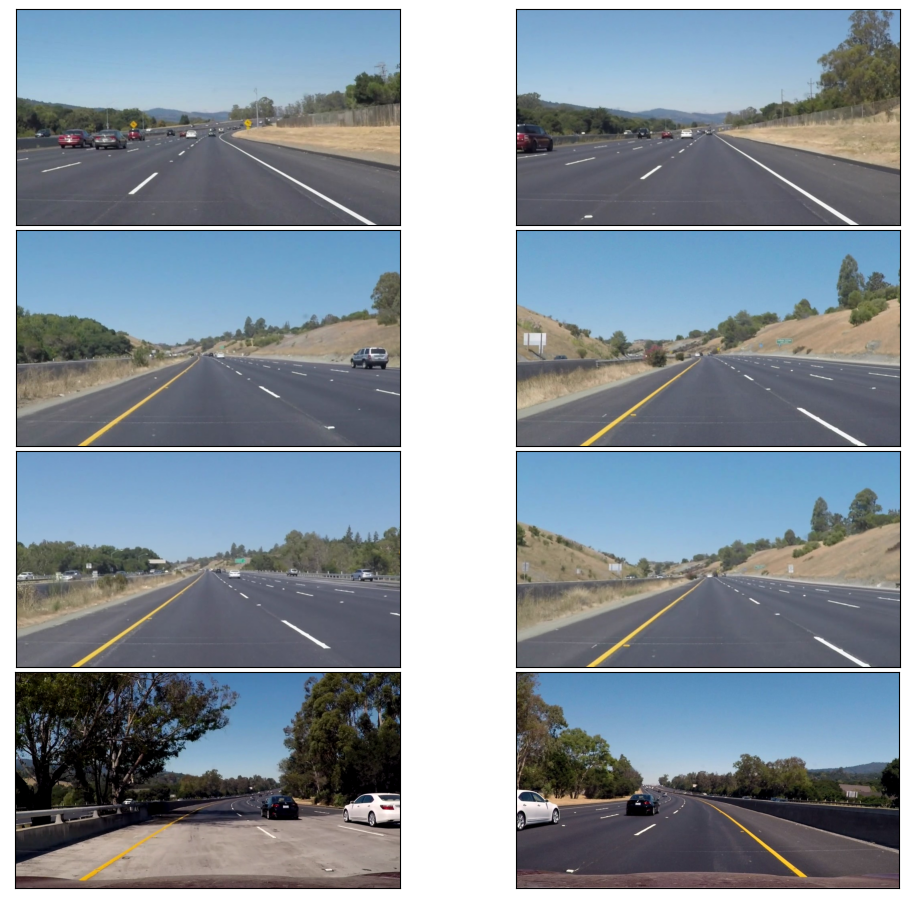

In [120]:
# test images
test_images = [plt.imread(img) for img in glob.glob('test_images/*.jpg')]
list_images(test_images)

In [121]:
def convert_hsl(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

# list_images(list(map(convert_hsl, test_images)))

In [122]:
def HSL_color_selection(image):
    converted_image = convert_hsl(image)
    
    lower_threshold = np.uint8([0, 200, 0])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    lower_threshold = np.uint8([10, 0, 100])
    upper_threshold = np.uint8([40, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

In [123]:
color_selected_images = list(map(HSL_color_selection, test_images))

In [124]:
# Image to grey scale image
def gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [125]:
gray_images = list(map(gray_scale, color_selected_images))
# list_images(gray_images)

In [126]:
# Smoothing of image
def gaussian_smoothing(image, kernel_size = 13):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)   

In [127]:
blur_images = list(map(gaussian_smoothing, gray_images))
# list_images(blur_images)

In [128]:
# Using canny edge detection to detect edges of road
def canny_detector(image, low_threshold = 50, high_threshold = 150):
    return cv2.Canny(image, low_threshold, high_threshold)

In [129]:
edge_detected_images = list(map(canny_detector, gray_images))
# list_images(edge_detected_images)

In [130]:
# Masking reagion of interest
def region_selection(image):
    mask = np.zeros_like(image)   
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    rows, cols = image.shape[:2]
    # bottom_left  = [cols * 0.1, rows * 0.95]
    # top_left     = [cols * 0.4, rows * 0.6]
    # bottom_right = [cols * 0.9, rows * 0.95]
    # top_right    = [cols * 0.6, rows * 0.6]
    bottom_left  = [cols*0.1, rows*0.95]
    top_left     = [cols*0.4, rows*0.6]
    bottom_right = [cols*0.9, rows*0.95]
    top_right    = [cols*0.6, rows*0.6] 

    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

In [131]:
masked_image = list(map(region_selection, edge_detected_images))
# list_images(masked_image)

In [132]:
# Mapping lines using haugh transform
def hough_transform(image):
    rho = 1
    theta = np.pi/180
    threshold = 30
    minLineLength = 50
    maxLineGap = 300
    return cv2.HoughLinesP(image, rho = rho, theta = theta, threshold = threshold,
                           minLineLength = minLineLength, maxLineGap = maxLineGap)

In [133]:
hough_lines = list(map(hough_transform, masked_image))

In [134]:
# Drawing lines on the image
def draw_lines(image, lines, color = [255, 0, 0], thickness = 2):
    image = np.copy(image)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

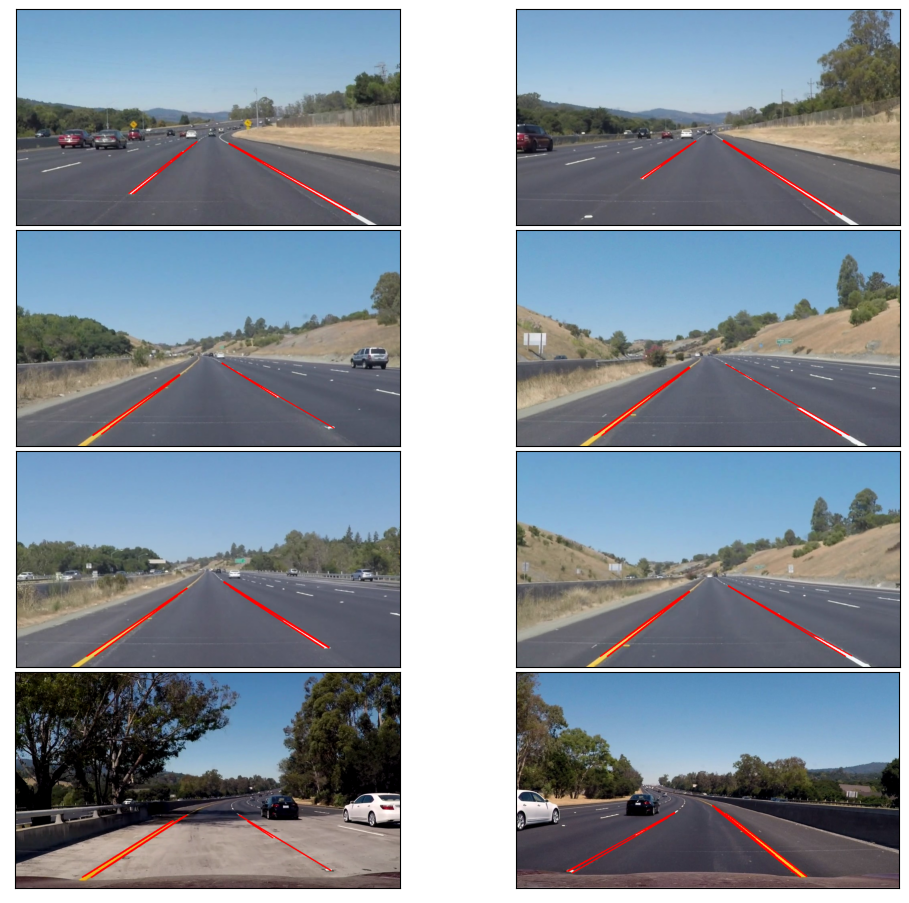

In [135]:
line_images = []
for image, lines in zip(test_images, hough_lines):
    line_images.append(draw_lines(image, lines))
    
list_images(line_images)

In [136]:
def map_coordinates(frame, parameters):
    
    height, width, _ = frame.shape
    slope, intercept = parameters
    
    if slope == 0:
        slope = 0.1
    
    y1 = height
    y2 = int(height*0.6)
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return [[x1, y1, x2, y2]]

In [137]:
# Otimizing the line by joining and streaching them
def optimize_lines(frame, lines):
    height, width, _ = frame.shape
    
    if lines is not None:
        lane_lines = []
        left_fit = []
        right_fit = []        
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)

            parameters = np.polyfit((x1, x2), (y1, y2), 1)
            slope = parameters[0]
            intercept = parameters[1]
            
            if slope < 0:
                left_fit.append((slope, intercept))
            else:   
                right_fit.append((slope, intercept))

        if len(left_fit) > 0:
            left_fit_average = np.average(left_fit, axis=0)
            lane_lines.append(map_coordinates(frame, left_fit_average))
            
        if len(right_fit) > 0:
            right_fit_average = np.average(right_fit, axis=0)
            lane_lines.append(map_coordinates(frame, right_fit_average))
        
    return lane_lines

In [138]:
opt_lines = []
for image, lines in zip(test_images, hough_lines):
    opt_lines.append(optimize_lines(image, lines))

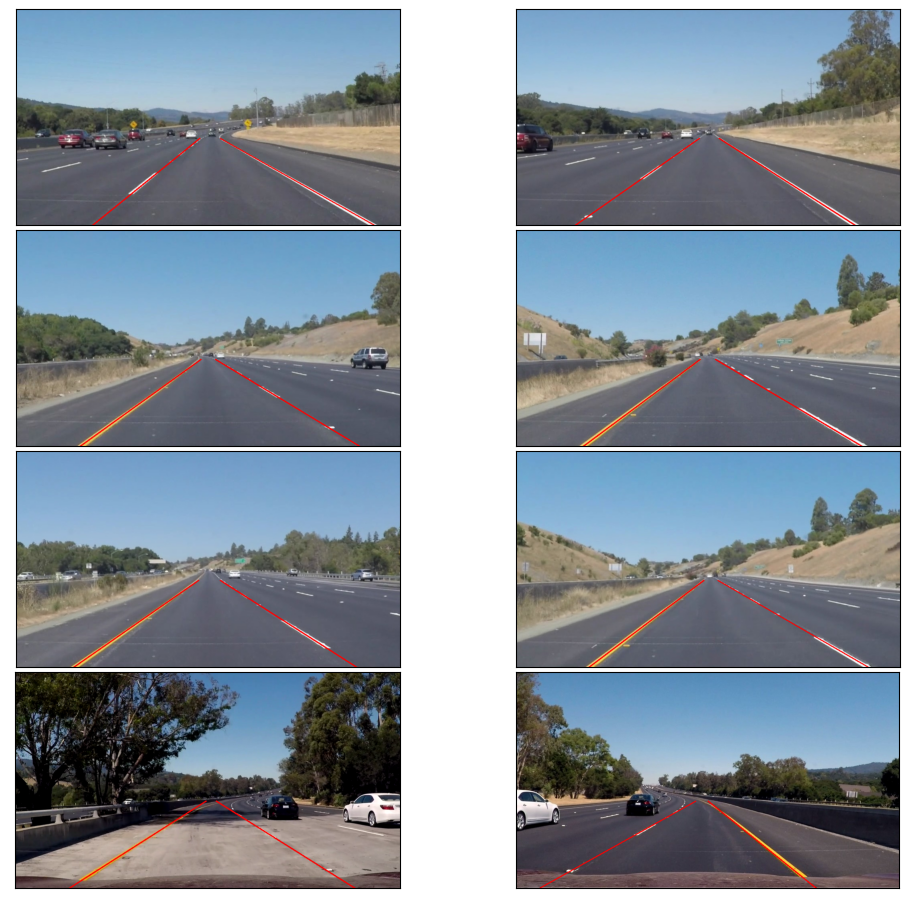

In [139]:
line_images = []
for image, lines in zip(test_images, opt_lines):
    line_images.append(draw_lines(image, lines))
    
list_images(line_images)

In [140]:
# Changing the prespective of the region of interst got get the top view
def warp_perspective(frame):
    height, width = image.shape[:2]
    source_points = np.float32(
                      [
                        [425, 330],
                        [112.5, height],
                        [900, height],
                        [565, 330],
                    ]
                  )
    offset = 50
    destination_points = np.float32([[offset, 0],
                      [offset, height],
                      [width-2*offset, height],
                      [width-2*offset, 0]])
    matrix = cv2.getPerspectiveTransform(source_points, destination_points) 
    skyview = cv2.warpPerspective(frame, matrix, (width, height))    
    return skyview

In [141]:
# Changing the prespective of the region of interst got get the top view
def reverse_warp(frame):
    height, width = image.shape[:2]
    source_points = np.float32(
                      [
                        [425, 330],
                        [112.5, height],
                        [900, height],
                        [565, 330],
                    ]
                  )
    offset = 50
    destination_points = np.float32([[offset, 0],
                      [offset, height],
                      [width-2*offset, height],
                      [width-2*offset, 0]])
    matrix = cv2.getPerspectiveTransform(destination_points, source_points) 
    skyview = cv2.warpPerspective(frame, matrix, (width, height))    
    return skyview

In [142]:
def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
    return np.sum(bottom_half, axis=0)

In [143]:
# def pixels_in_window(center, margin, height):
#     topleft = (center[0]-margin, center[1]-height//2)
#     bottomright = (center[0]+margin, center[1]+height//2)
#     print(nonzerox)
#     condx = (topleft[0] <= nonzerox) & (nonzerox <= bottomright[0])
#     condy = (topleft[1] <= nonzeroy) & (nonzeroy <= bottomright[1])
#     return nonzerox[condx&condy], nonzeroy[condx&condy]

In [144]:
# def extract_features(img):
#     img = img
#     # Height of of windows - based on nwindows and image shape
#     global window_height
#     window_height = np.int64(img.shape[0]//nwindows)

#     # Identify the x and y positions of all nonzero pixel in the image
#     nonzero = img.nonzero()
#     nonzerox = np.array(nonzero[1])
#     nonzeroy = np.array(nonzero[0])


In [145]:
# def find_lane_pixels(img):
#     assert(len(img.shape) == 2)

#     out_img = np.dstack((img, img, img))

#     histogram = hist(img)
#     midpoint = histogram.shape[0]//2
#     leftx_base = np.argmax(histogram[:midpoint])
#     rightx_base = np.argmax(histogram[midpoint:]) + midpoint

#     leftx_current = leftx_base
#     rightx_current = rightx_base
#     y_current = img.shape[0] + window_height//2

#     leftx, lefty, rightx, righty = [], [], [], []

#     for _ in range(nwindows):
#         y_current -= window_height
#         center_left = (leftx_current, y_current)
#         center_right = (rightx_current, y_current)

#         good_left_x, good_left_y = pixels_in_window(center_left, margin, window_height)
#         good_right_x, good_right_y = pixels_in_window(center_right, margin, window_height)

#         # Append these indices to the lists
#         leftx.extend(good_left_x)
#         lefty.extend(good_left_y)
#         rightx.extend(good_right_x)
#         righty.extend(good_right_y)

#         if len(good_left_x) > minpix:
#             leftx_current = np.int32(np.mean(good_left_x))
#         if len(good_right_x) > minpix:
#             rightx_current = np.int32(np.mean(good_right_x))

#     return leftx, lefty, rightx, righty, out_img


In [146]:

# def fit_poly(img):
#     leftx, lefty, rightx, righty, out_img = find_lane_pixels(img)

#     if len(lefty) > 1500:
#         left_fit = np.polyfit(lefty, leftx, 2)
#     if len(righty) > 1500:
#         right_fit = np.polyfit(righty, rightx, 2)

#     maxy = img.shape[0] - 1
#     miny = img.shape[0] // 3
#     if len(lefty):
#         maxy = max(maxy, np.max(lefty))
#         miny = min(miny, np.min(lefty))

#     if len(righty):
#         maxy = max(maxy, np.max(righty))
#         miny = min(miny, np.min(righty))

#     ploty = np.linspace(miny, maxy, img.shape[0])

#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#     # Visualization
#     for i, y in enumerate(ploty):
#         l = int(left_fitx[i])
#         r = int(right_fitx[i])
#         y = int(y)
#         cv2.line(out_img, (l, y), (r, y), (0, 255, 0))

#     return out_img


In [147]:

# def plot(out_img):
#     np.set_printoptions(precision=6, suppress=True)
#     value = None
#     if abs(left_fit[0]) > abs(right_fit[0]):
#         value = left_fit[0]
#     else:
#         value = right_fit[0]

#     if abs(value) <= 0.00015:
#         dir.append('F')
#     elif value < 0:
#         dir.append('L')
#     else:
#         dir.append('R')
    
#     if len(dir) > 10:
#         dir.pop(0)

#     W = 400
#     H = 500
#     widget = np.copy(out_img[:H, :W])
#     widget //= 2
#     widget[0,:] = [0, 0, 255]
#     widget[-1,:] = [0, 0, 255]
#     widget[:,0] = [0, 0, 255]
#     widget[:,-1] = [0, 0, 255]
#     out_img[:H, :W] = widget

#     direction = max(set(dir), key = dir.count)
#     msg = "Keep Straight Ahead"
#     if direction == 'L':
#         msg = "Left Curve Ahead"
#     if direction == 'R':
#         msg = "Right Curve Ahead"
#     if direction == 'F':
#         msg = "Keep Straight Ahead"

#     cv2.putText(out_img, msg, org=(10, 240), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

#     return out_img

In [148]:
# def forward(img):
#     extract_features(img)
#     print(nonzerox)
#     return fit_poly(img)

In [149]:
class LaneLines:
    def __init__(self):
        self.left_fit = None
        self.right_fit = None
        self.binary = None
        self.nonzero = None
        self.nonzerox = None
        self.nonzeroy = None
        self.clear_visibility = True
        self.dir = []

        self.nwindows = 9
        self.margin = 100
        self.minpix = 50
# P
    def forward(self, img):
        self.extract_features(img)
        return self.fit_poly(img)

    def pixels_in_window(self, center, margin, height):
        topleft = (center[0]-margin, center[1]-height//2)
        bottomright = (center[0]+margin, center[1]+height//2)

        condx = (topleft[0] <= self.nonzerox) & (self.nonzerox <= bottomright[0])
        condy = (topleft[1] <= self.nonzeroy) & (self.nonzeroy <= bottomright[1])
        return self.nonzerox[condx&condy], self.nonzeroy[condx&condy]
# D
    def extract_features(self, img):
        self.img = img
        self.window_height = np.int64(img.shape[0]//self.nwindows)

        self.nonzero = img.nonzero()
        self.nonzerox = np.array(self.nonzero[1])
        self.nonzeroy = np.array(self.nonzero[0])

    def find_lane_pixels(self, img):
        assert(len(img.shape) == 2)

        out_img = np.dstack((img, img, img))

        histogram = hist(img)
        midpoint = histogram.shape[0]//2
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        leftx_current = leftx_base
        rightx_current = rightx_base
        y_current = img.shape[0] + self.window_height//2

        leftx, lefty, rightx, righty = [], [], [], []

        for _ in range(self.nwindows):
            y_current -= self.window_height
            center_left = (leftx_current, y_current)
            center_right = (rightx_current, y_current)

            good_left_x, good_left_y = self.pixels_in_window(center_left, self.margin, self.window_height)
            good_right_x, good_right_y = self.pixels_in_window(center_right, self.margin, self.window_height)

            leftx.extend(good_left_x)
            lefty.extend(good_left_y)
            rightx.extend(good_right_x)
            righty.extend(good_right_y)

            if len(good_left_x) > self.minpix:
                leftx_current = np.int32(np.mean(good_left_x))
            if len(good_right_x) > self.minpix:
                rightx_current = np.int32(np.mean(good_right_x))

        return leftx, lefty, rightx, righty, out_img

    def fit_poly(self, img):
        leftx, lefty, rightx, righty, out_img = self.find_lane_pixels(img)

        if len(lefty) > 1500:
            self.left_fit = np.polyfit(lefty, leftx, 2)
        if len(righty) > 1500:
            self.right_fit = np.polyfit(righty, rightx, 2)

        maxy = img.shape[0] - 1
        miny = img.shape[0] // 3
        if len(lefty):
            maxy = max(maxy, np.max(lefty))
            miny = min(miny, np.min(lefty))

        if len(righty):
            maxy = max(maxy, np.max(righty))
            miny = min(miny, np.min(righty))

        ploty = np.linspace(miny, maxy, img.shape[0])

        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        for i, y in enumerate(ploty):
            l = int(left_fitx[i])
            r = int(right_fitx[i])
            y = int(y)
            cv2.line(out_img, (l, y), (r, y), (0, 255, 0))

        return out_img

    def plot(self, out_img):
        np.set_printoptions(precision=6, suppress=True)

        value = None
        if abs(self.left_fit[0]) > abs(self.right_fit[0]):
            value = self.left_fit[0]
        else:
            value = self.right_fit[0]

        if abs(value) <= 0.00015:
            self.dir.append('F')
        elif value < 0:
            self.dir.append('L')
        else:
            self.dir.append('R')
        
        if len(self.dir) > 10:
            self.dir.pop(0)

        W = 400
        H = 500
        widget = np.copy(out_img[:H, :W])
        widget //= 2
        widget[0,:] = [0, 0, 255]
        widget[-1,:] = [0, 0, 255]
        widget[:,0] = [0, 0, 255]
        widget[:,-1] = [0, 0, 255]
        out_img[:H, :W] = widget

        direction = max(set(self.dir), key = self.dir.count)
        msg = "Keep Straight Ahead"
        if direction == 'L':
            msg = "Left Curve Ahead"
        if direction == 'R':
            msg = "Right Curve Ahead"
        if direction == 'F':
            msg = "Keep Straight Ahead"

        cv2.putText(out_img, msg, org=(10, 240), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
        return out_img


In [150]:
def process_frame(image):
    # global left_fit
    # left_fit = None
    # global right_fit
    # right_fit = None
    # global binary
    # binary = None
    # global nonzero
    # nonzero = None
    # global nonzerox
    # nonzerox = None
    # global nonzeroy
    # nonzeroy = None
    # global clear_visibility
    # clear_visibility = True
    # global dir
    # dir = []

    # global nwindows
    # nwindows = 9
    # global margin
    # margin = 100
    # global minpix
    # minpix = 50

    out_img = np.copy(image)
    color_select = HSL_color_selection(image)
    gray         = gray_scale(color_select)
    smooth       = gaussian_smoothing(gray)
    edges        = canny_detector(smooth)
    masked_image       = region_selection(edges)
    hough_line = hough_transform(masked_image)
    opt_line = optimize_lines(image, hough_line)
    line_image = draw_lines(image, opt_line)
    im = warp_perspective(masked_image)
    lanelines = LaneLines()
    img = lanelines.forward(im)
    img = reverse_warp(img)
    # print(out_img.shape, cv2.resize(img, (out_img.shape[1], out_img.shape[0])).shape)
    out_img = cv2.addWeighted(out_img, 1, cv2.resize(img, (out_img.shape[1], out_img.shape[0])), 0.6, 0)
    out_img = lanelines.plot(out_img)
    return out_img
    

In [151]:
def process_video(input_path, output_path):
    clip = VideoFileClip(os.path.join('test_videos', input_path), audio=False)
    out_clip = clip.fl_image(process_frame)
    out_clip.write_videofile(os.path.join('op_videos', output_path), audio=False)

In [154]:
%time process_video('solidYellowLeft.mp4', 'op5.mp4')

                                                              
                                                              
t:  43%|████▎     | 290/681 [05:49<00:25, 15.04it/s, now=None]

Moviepy - Building video op_videos\op5.mp4.
Moviepy - Writing video op_videos\op5.mp4



TypeError: 'NoneType' object is not subscriptable